import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [118]:
x = np.linspace(-3, 3, 100)

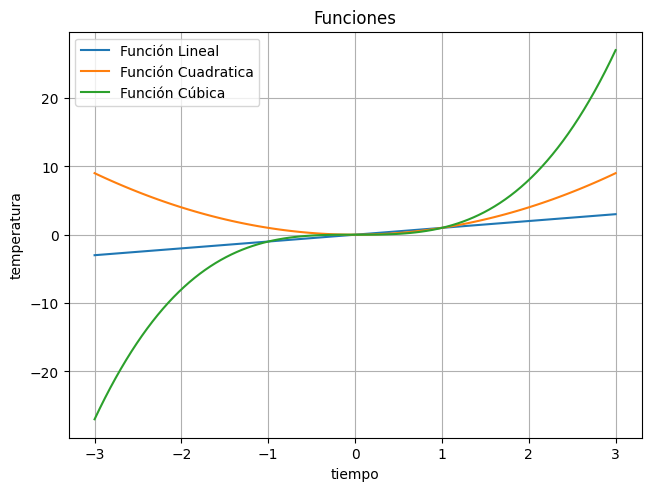

In [122]:
fig, axis = plt.subplots(layout='constrained')
axis.plot(x, x, label='Función Lineal')
axis.plot(x, x**2, label='Función Cuadratica')
axis.plot(x, x**3, label="Función Cúbica")
axis.grid()

axis.set_title('Funciones')
axis.set_xlabel("tiempo")
axis.set_ylabel("temperatura")
axis.legend()
plt.show()

# Estilo Pyplot

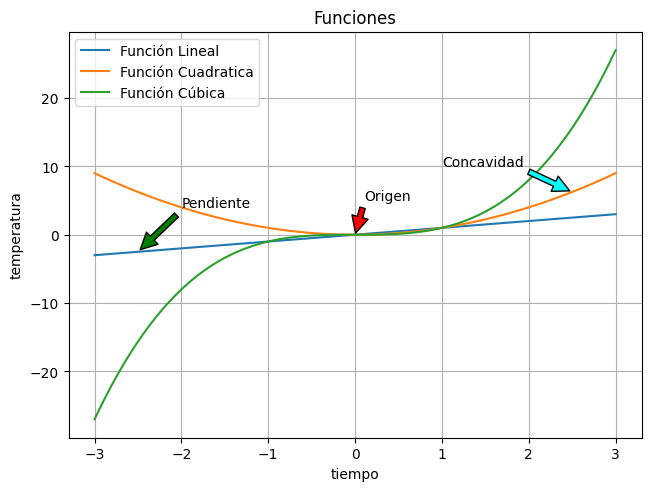

In [156]:
plt.figure(layout='constrained')
plt.plot(x, x, label='Función Lineal')
plt.plot(x, x**2, label='Función Cuadratica')
plt.plot(x, x**3, label="Función Cúbica")
plt.grid()

plt.title('Funciones')
plt.xlabel("tiempo")
plt.ylabel("temperatura")
plt.legend()
plt.annotate('Origen', xy=(0,0), xytext=(1/10,5), arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Pendiente', xy=(-2.5,-2.5), xytext=(-2,4), arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate('Concavidad', xy=(2.5,6.25), xytext=(1,10), arrowprops=dict(facecolor='cyan', shrink=0.05))
plt.show()

# Renderizado más rápido usando blitting

Blitting es una técnica estándar en gráficos de trama que, en el contexto de Matplotlib, se puede utilizar para mejorar (drásticamente) el rendimiento de las figuras interactivas. Por ejemplo, los módulos animationy widgetsusan blitting internamente. Aquí, demostramos cómo implementar su propio blitting, fuera de estas clases.

Blit acelera el dibujo repetitivo al convertir todos los elementos gráficos que no cambian en una imagen de fondo una vez. Luego, para cada dibujo, solo los elementos cambiantes deben dibujarse en este fondo. Por ejemplo, si los límites de un eje no han cambiado, podemos representar los ejes vacíos, incluidas todas las marcas y etiquetas, una vez, y solo dibujar los datos cambiantes más tarde.

La estrategia es

- Prepare el fondo constante:

    - Dibuja la figura, pero excluye a todos los artistas que quieras animar marcándolos como animados (ver ``Artist.set_animated``).

    - Guarde una copia del búfer RBGA.

- Renderice las imágenes individuales:

    - Restaure la copia del búfer RGBA.

    - Vuelva a dibujar los artistas animados usando ``Axes.draw_artist``/`` Figure.draw_artist``.

    - Muestre la imagen resultante en la pantalla.

Una consecuencia de este procedimiento es que sus artistas animados siempre se dibujan encima de los artistas estáticos.

No todos los backends admiten blitting. Puede verificar si un lienzo determinado lo hace a través de la ``FigureCanvasBase.supports_blit`` propiedad.

## Ejemplo mínimo 

Podemos usar los ``FigureCanvasAgg`` métodos ``copy_from_bbox`` y ``restore_region`` junto con la configuración ``animated=True`` de nuestro artista para implementar un ejemplo mínimo que use blitting para acelerar el renderizado.

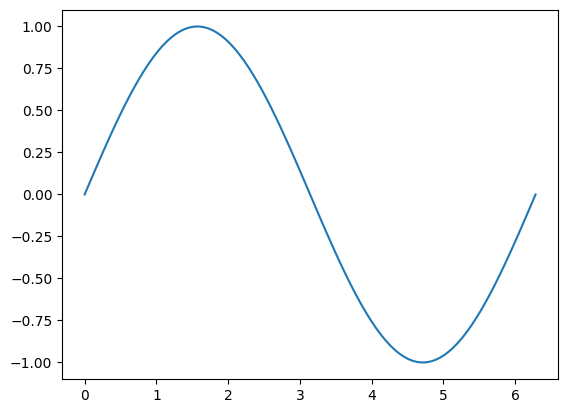

In [2]:

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 100)

fig, ax = plt.subplots()

# animated=True tells matplotlib to only draw the artist when we
# explicitly request it
(ln,) = ax.plot(x, np.sin(x), animated=True)

# make sure the window is raised, but the script keeps going
plt.show(block=False)

# stop to admire our empty window axes and ensure it is rendered at
# least once.
#
# We need to fully draw the figure at its final size on the screen
# before we continue on so that :
#  a) we have the correctly sized and drawn background to grab
#  b) we have a cached renderer so that ``ax.draw_artist`` works
# so we spin the event loop to let the backend process any pending operations
plt.pause(0.1)

# get copy of entire figure (everything inside fig.bbox) sans animated artist
bg = fig.canvas.copy_from_bbox(fig.bbox)
# draw the animated artist, this uses a cached renderer
ax.draw_artist(ln)
# show the result to the screen, this pushes the updated RGBA buffer from the
# renderer to the GUI framework so you can see it
fig.canvas.blit(fig.bbox)

for j in range(100):
    # reset the background back in the canvas state, screen unchanged
    fig.canvas.restore_region(bg)
    # update the artist, neither the canvas state nor the screen have changed
    ln.set_ydata(np.sin(x + (j / 100) * np.pi))
    # re-render the artist, updating the canvas state, but not the screen
    ax.draw_artist(ln)
    # copy the image to the GUI state, but screen might not be changed yet
    fig.canvas.blit(fig.bbox)
    # flush any pending GUI events, re-painting the screen if needed
    fig.canvas.flush_events()
    # you can put a pause in if you want to slow things down
    # plt.pause(.1)